# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='int32')

Plot the training data

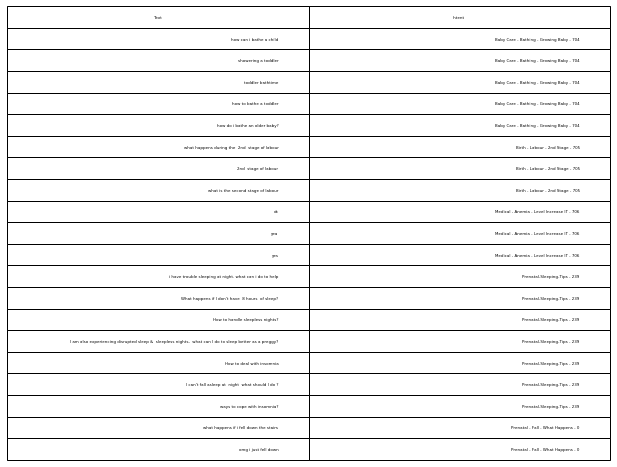

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
lookup = np.eye(num_classes)
y_train = np.array([lookup[label] for label in y_train], dtype='float32')

Start training the classification model and save

In [8]:
from keras_preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

In [9]:
X_train = tokenizer.texts_to_sequences(X_train)

In [10]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

ngram_range = 3
print('Adding {}-gram features'.format(ngram_range))
# Create set of unique n-gram from the training set.
ngram_set = set()
for input_list in X_train:
    for i in range(2, ngram_range + 1):
        set_of_ngram = create_ngram_set(input_list, ngram_value=i)
        ngram_set.update(set_of_ngram)

start_index = 20000 + 1
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
indice_token = {token_indice[k]: k for k in token_indice}

# max_features is the highest integer that could be found in the dataset.
max_features = np.max(list(indice_token.keys())) + 1

X_train = add_ngram(X_train, token_indice, ngram_range)

Adding 3-gram features


In [11]:
import keras
from keras_preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=50)

Using TensorFlow backend.


In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    300,
                    input_length=50))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())
model.add(Dense(100))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train,
          batch_size=64,
          epochs=5)

Epoch 1/5
10256/10256 [==============================] - 85s 8ms/step - loss: 7.1885 - acc: 0.0064
Epoch 2/5
10256/10256 [==============================] - 73s 7ms/step - loss: 6.9222 - acc: 0.0076
Epoch 3/5
10256/10256 [==============================] - 83s 8ms/step - loss: 6.6824 - acc: 0.0080
Epoch 4/5
10256/10256 [==============================] - 79s 8ms/step - loss: 6.4970 - acc: 0.0082
Epoch 5/5
10256/10256 [==============================] - 85s 8ms/step - loss: 6.3104 - acc: 0.0073


In [14]:
X_test = ['hello world', 'please, no', 'the earth is flat']
X_test = tokenizer.texts_to_sequences(X_test)
X_test = add_ngram(X_test, token_indice, ngram_range)
X_test = pad_sequences(X_test, maxlen=50)

logits = model.predict(X_test)

In [15]:
np.max(logits, 1)

array([0.95575815, 0.8994302 , 0.8759807 ], dtype=float32)

In [16]:
classes[160]

'Medical - Eclampsia - Treatment'